# Section 1 Data Analysis

***a)*** The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes.

Classes:
1. Airplane
2. Automobile
3. Bird
4. Cat
5. Dear
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck
    
***b)*** The classes are completely mutually exclusive. Each category has 6,000 images, and in each image include only one object. Augmentation: Is it possible to use augmentation, such as horizontal flip, to have more data to train on. Horizontal flip will be valid because in this data set, we will want to classify object like trucks\airplanes regardless of the driving direction.

***c)*** There are 50000 training images and 10000 test images. The data is balanced beause each category has exacly 6,000 images. For validation we will use hyprparameter "validation_split" for using 80% of the data for train and 20% of the data of validation. We feel ok to choose a basic way to split the validation becuase cifar10 is balanced and have good amount of example for each class. Shuffling the data and choose random 20% for validation might affect the overfitting problem in a good way.

***d)*** There are several method that used on this dataset. The best results is 98.52% and described in the following article : https://arxiv.org/pdf/1805.09501.pdf .
5 of the best benchmark (from https://benchmarks.ai/cifar-10) were using data augmentation for images,
regularization methods and andom erasing.

***e)*** 
Rows in this order : 
airplane										
automobile										
bird										
cat										
deer										
dog										
frog										
horse										
ship										
truck
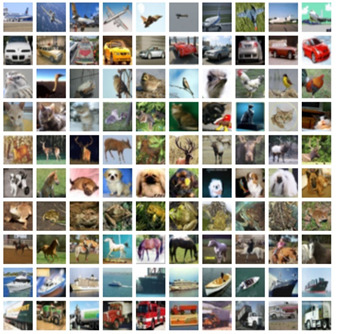

We can guess that airplane and ships are going to be hard prediction due to the blue background of sky and the sea. 
also the different between deer and dog may be confusing.

# Section 2


***a)*** We choosed to split the data to: 50,000 samples for training and 10,000 samples for testing. According to common divisions, we choosed to split randomly 20% of the data for the training to be used for validation.

In [1]:
from __future__ import print_function

import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
import seaborn as sns
import os
import json

from keras.models import Model, Sequential, model_from_json,clone_model
from keras.datasets import cifar10
from keras.layers import *
from keras.utils import to_categorical, np_utils
import tensorflow as tf

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# y_train = np_utils.to_categorical(y_train,10) #for augmentation
# y_test = np_utils.to_categorical(y_test,10)
print('X_train shape is: {} \n\
y_train shape is: {}'.format(X_train.shape,y_train.shape))
print()
print('X_test shape is: {} \n\
y_test shape is: {}'.format(X_test.shape,y_test.shape))

170500096/170498071 [==============================] - 33s 0us/step
X_train shape is: (50000, 32, 32, 3) 
y_train shape is: (50000, 1)

X_test shape is: (10000, 32, 32, 3) 
y_test shape is: (10000, 1)


### function for saving and reading models and models history

In [0]:
def save_model(model,filename):
    # this is a helper function used to save a keras NN model architecture and weights
    json_string = model.to_json()
    if not os.path.isdir('cache'):
        os.mkdir('cache')
    open(os.path.join('cache', filename+'_architecture.json'), 'w').write(json_string)
    model.save_weights(os.path.join('cache', filename+'_model_weights.h5'), overwrite=True)
    
def read_model(filename):
    # this is a helper function used to restore a keras NN model architecture and weights
    model = model_from_json(open(os.path.join('cache', filename+'_architecture.json')).read())
    model.load_weights(os.path.join('cache', filename+'_model_weights.h5'))
    return model

def save_model_info(hist,filename):
    if not os.path.isdir('cache'):
        os.mkdir('cache')
    with open(os.path.join('cache', filename+'_architecture.json'), 'w') as f:
        json.dump(hist.history, f)
    f.close()
    
def read_model_info(filename):
    with open(os.path.join('cache', filename+'_architecture.json'), 'r') as f:
        return json.load(f)

### functions for result visualization

In [0]:
def plot_multiple_imgs(X,y,nrow=2,ncol=2,figsize=(13,7),preds=None,skip=0):
    fig,ax = plt.subplots(nrows=nrow,ncols=ncol,figsize=figsize)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(nrow*ncol):
        ax[i//ncol,i%ncol].imshow(X[skip+i],cmap='binary')
        ax[i//ncol,i%ncol].set_xticks([])
        ax[i//ncol,i%ncol].set_yticks([])
        if preds is not None:
            ax[i//ncol,i%ncol].text(0.65, 0.1, str(preds[skip+i]), transform=ax[i//ncol,i%ncol].transAxes,
                                   color='green' if y[skip+i]==preds[skip+i] else 'red',weight='bold')
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
        else:
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
    plt.show()
    
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history['acc'])+1),model_history['acc'])
    axs[0].plot(range(1,len(model_history['val_acc'])+1),model_history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history['acc'])+1),len(model_history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history['loss'])+1),model_history['loss'])
    axs[1].plot(range(1,len(model_history['val_loss'])+1),model_history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history['loss'])+1),len(model_history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
def print_bad_good_preds(images, labels,model):
    class_map = {0:'Airplane',1:'Automobile',2:'Bird',3:'Cat',4:'Dear',5:'Dog',6:'Frog',7:'Horse',8:'Ship',9:'Truck'}
    preds = np.argmax( model.predict(images), axis=1)
    wrong_preds = np.empty((3,))
    good_preds = np.empty((3,))
    flat_labels = labels.reshape(len(labels))
    for i in range(0, len(flat_labels)):
        new_row =  np.array([images[i],class_map[flat_labels[i]],class_map[preds[i]]])
        if flat_labels[i] != preds[i]:
          wrong_preds = np.vstack((wrong_preds, new_row))
        else:
          good_preds = np.vstack((good_preds, new_row))
    print("Bad prediction")
    plot_multiple_imgs(wrong_preds[:,0],wrong_preds[:,1],5,5,(15,15),wrong_preds[:,2], skip=500)
    print("\nGood prediction")
    plot_multiple_imgs(good_preds[:,0],good_preds[:,1],5,5,(15,15),good_preds[:,2],skip=500)
    
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    test_y = np.reshape(test_y,len(test_y),)
    predicted_class = np.argmax(result, axis=1)
    num_correct = np.sum(predicted_class == test_y) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

def print_confusion_matrix(X, y, model):
  preds = np.argmax(model.predict(X), axis=1)
  sns.heatmap(confusion_matrix(y, preds),cmap='Greens',annot=True, fmt='d')
  plt.xlabel('Prediction')
  plt.ylabel('True label')
  plt.title('Cifar10 Convolutional model \n classification results on test set')
  print()

## First model

***b)***

In [0]:
model = Sequential()
model.add(Conv2D(48, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(48, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(96, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(96, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(192, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(192, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 48)        20784     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 48)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 96)        41568     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 96)        83040     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 96)          0         
__________

In [0]:
batch_size = 32
epochs = 30
validation_split = 0.2

In [0]:
start_time = time.time()
model_info = model.fit(X_train,to_categorical(y_train),batch_size = batch_size,validation_split=validation_split,shuffle=True,epochs=epochs)
end_time = time.time()

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 108s 3ms/step - loss: 1.9958 - acc: 0.2888 - val_loss: 1.7026 - val_acc: 0.3685
Epoch 2/30
40000/40000 [==============================] - 97s 2ms/step - loss: 1.5760 - acc: 0.4225 - val_loss: 1.4240 - val_acc: 0.4945
Epoch 3/30
40000/40000 [==============================] - 96s 2ms/step - loss: 1.4268 - acc: 0.4906 - val_loss: 1.2777 - val_acc: 0.5480
Epoch 4/30
40000/40000 [==============================] - 96s 2ms/step - loss: 1.3212 - acc: 0.5318 - val_loss: 1.2119 - val_acc: 0.5703
Epoch 5/30
40000/40000 [==============================] - 97s 2ms/step - loss: 1.2495 - acc: 0.5624 - val_loss: 1.1957 - val_acc: 0.5649
Epoch 6/30
40000/40000 [==============================] - 97s 2ms/step - loss: 1.2051 - acc: 0.5782 - val_loss: 1.0767 - val_acc: 0.6224
Epoch 7/30
40000/40000 [==============================] - 96s 2ms/step - loss: 1.1805 - acc: 0.5902 - val_loss: 1.0590 - val_ac

In [0]:
save_model(model,'saved_model')
save_model_info(model_info,'saved_model_info')

In [0]:
model = read_model(filename='saved_model')
most_history = read_model_info('saved_model_info')

### Preditction results (example for good and bad classification ) :

Bad prediction


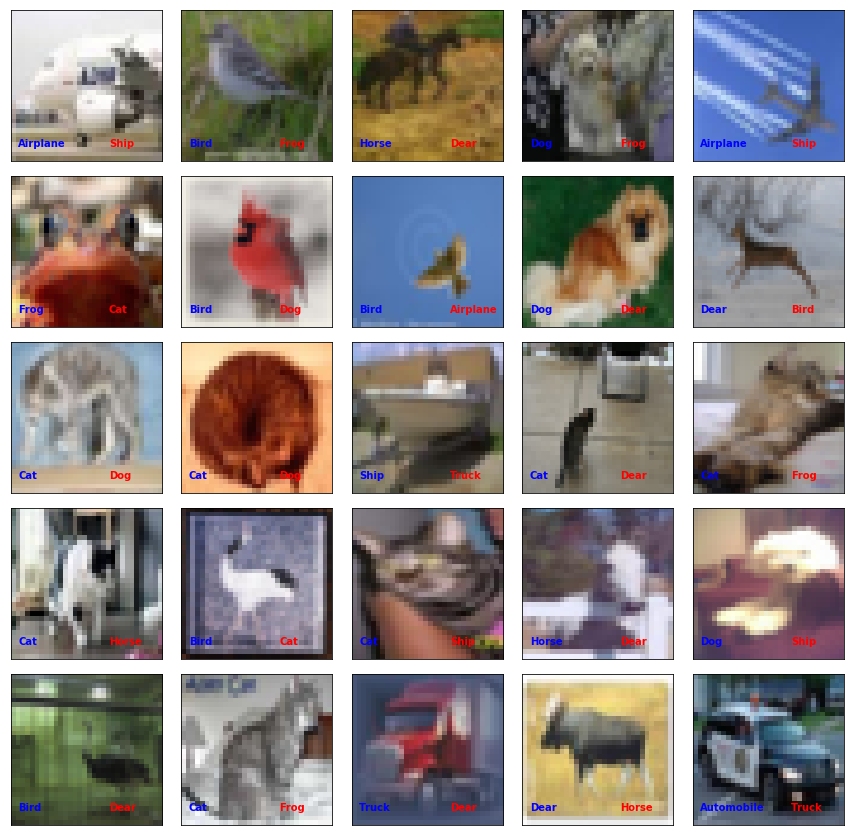


Good prediction


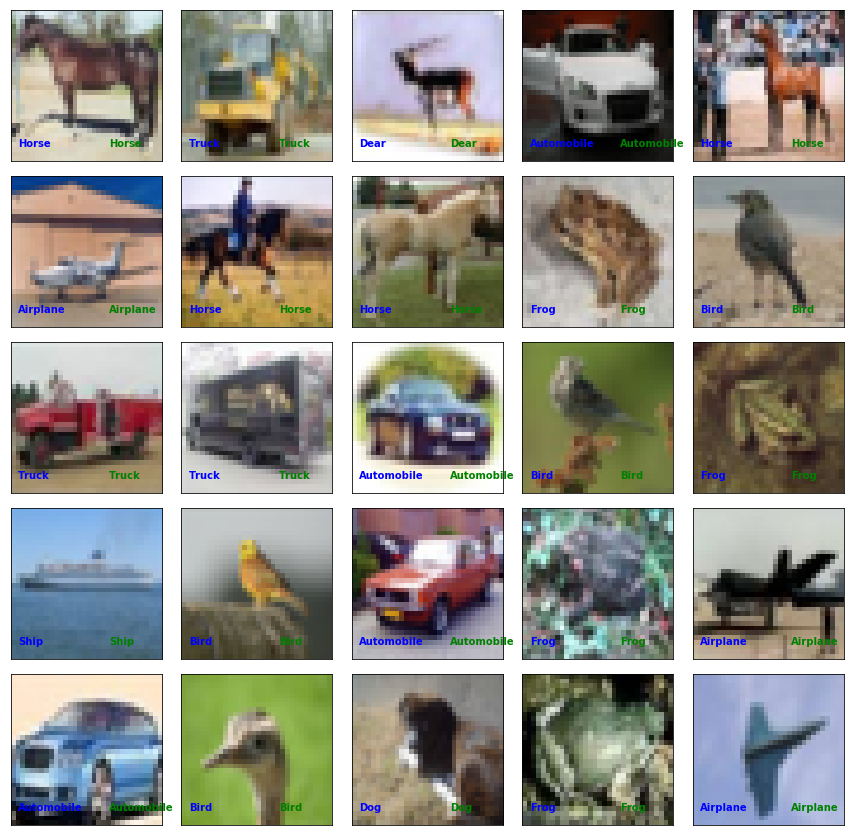

In [0]:
print_bad_good_preds(X_test, y_test, model)

### Error analysis


We can see below the "bad prediction" title which represented above the following mistakes:
in raw number 4 and column number 2 (index starts at 1) we can see a tough example because the sample include a cat which can easily mistaken by a stork (bird) and indeed the bad prediction was "Bird".


Another tough example we can see in raw 2, cloumn 3 A bird with its wings spread out so it's look like a small airplane. In addiotion we can observe in the "Good prediction" title (above this cell) in raw 5 and column 5 an airplane at a similar position as the bird. 

### Confusion matrix

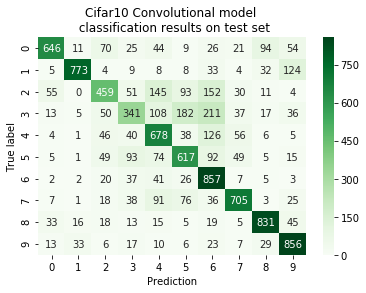

In [0]:
print_confusion_matrix(X_test, y_test, model)

We can see in the confusion matrix that cell [2,4]-> bird and dear (what??)  , [2,6]-> bird and frog (what2??) giving bad results. The best result recieved in cell [9.9] -> truck.

### model history and accuracy on test

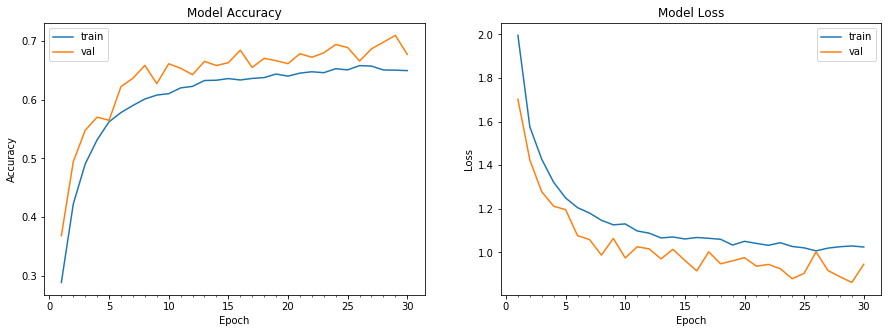

Model took 2936.31 seconds to train
Accuracy on test data is: 67.63


In [0]:
# plot model history
plot_model_history(model_info.history)
print("Model took %0.2f seconds to train"%(end_time - start_time))
# compute test accuracy
print("Accuracy on test data is: %0.2f"%(accuracy(X_test, y_test, model)))

***c)*** why is the model misclassifying:
1. The model might not have enough epochs or to big batches. In practice, small to moderate mini-batches (10-500) are generally used, combined with a decaying learning rate, which guarantees long run convergence while maintaining the power to jump out of shallow minima that are encountered early on.
2. It is possobeal the we choose a "week" optimaiter. we can improve the model praformanc by using the 'adamax' optimaizer insted of 'adam' and get a much better model that can be more robust. that is according to the update formula of 'adamax' when the current gradient is close to zero its completely ignore so the weights are influenced by fewer gradients and that makes the algorithm more robust to noise in the gradients.
3. We can improve the model by using batch normalization. that becuase in between the hidden layers the input of the next layer can be with different scale. so, by using normalizing we don't have to worry about the scale of input features would be extremly different. Thus, the gradient descent can reduce the oscillations when approaching the minimum point and converge faster.
    

***d)***
    Implement of learning rate: use adamax optimizer instead of adam.

In [0]:
adamax_model = Sequential()
adamax_model.add(Conv2D(48, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
adamax_model.add(Conv2D(48, (3, 3), activation='relu'))
adamax_model.add(MaxPooling2D(pool_size=(2, 2)))
adamax_model.add(Dropout(0.25))
adamax_model.add(Conv2D(96, (3, 3), activation='relu', padding='same'))
adamax_model.add(Conv2D(96, (3, 3), activation='relu'))
adamax_model.add(MaxPooling2D(pool_size=(2, 2)))
adamax_model.add(Dropout(0.25))
adamax_model.add(Conv2D(192, (3, 3), activation='relu', padding='same'))
adamax_model.add(Conv2D(192, (3, 3), activation='relu'))
adamax_model.add(MaxPooling2D(pool_size=(2, 2)))
adamax_model.add(Dropout(0.25))
adamax_model.add(Flatten())
adamax_model.add(Dense(256,activation='relu'))
adamax_model.add(Dropout(0.5))
adamax_model.add(Dense(10, activation='softmax'))
adamax_model.compile(loss='categorical_crossentropy',optimizer='adamax',metrics=['accuracy'])
adamax_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 48)        20784     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 48)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 15, 48)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 96)        41568     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 13, 96)        83040     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 96)          0         
__________

In [0]:
start_time = time.time()
adamax_model_info = adamax_model.fit(X_train,to_categorical(y_train),validation_split=validation_split,shuffle=True,epochs=epochs)
end_time = time.time()

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 93s 2ms/step - loss: 8.8747 - acc: 0.1492 - val_loss: 1.7247 - val_acc: 0.3567
Epoch 2/30
40000/40000 [==============================] - 93s 2ms/step - loss: 1.5957 - acc: 0.4098 - val_loss: 1.2907 - val_acc: 0.5371
Epoch 3/30
40000/40000 [==============================] - 93s 2ms/step - loss: 1.3070 - acc: 0.5338 - val_loss: 1.1162 - val_acc: 0.6096
Epoch 4/30
40000/40000 [==============================] - 93s 2ms/step - loss: 1.1145 - acc: 0.6104 - val_loss: 0.9456 - val_acc: 0.6667
Epoch 5/30
40000/40000 [==============================] - 93s 2ms/step - loss: 0.9950 - acc: 0.6539 - val_loss: 0.8686 - val_acc: 0.6980
Epoch 6/30
40000/40000 [==============================] - 93s 2ms/step - loss: 0.9035 - acc: 0.6885 - val_loss: 0.7900 - val_acc: 0.7267
Epoch 7/30
40000/40000 [==============================] - 93s 2ms/step - loss: 0.8438 - acc: 0.7081 - val_loss: 0.7957 - val_acc

In [0]:
save_model(adamax_model,'adamax_model')
save_model_info(adamax_model_info,'adamax_model_info')

In [0]:
most_history = read_model_info('optmizer_improved_model_info')
adamax_model = read_model(filename='adamax_model')

### Preditction results (example for good and bad classification ) :

Bad prediction


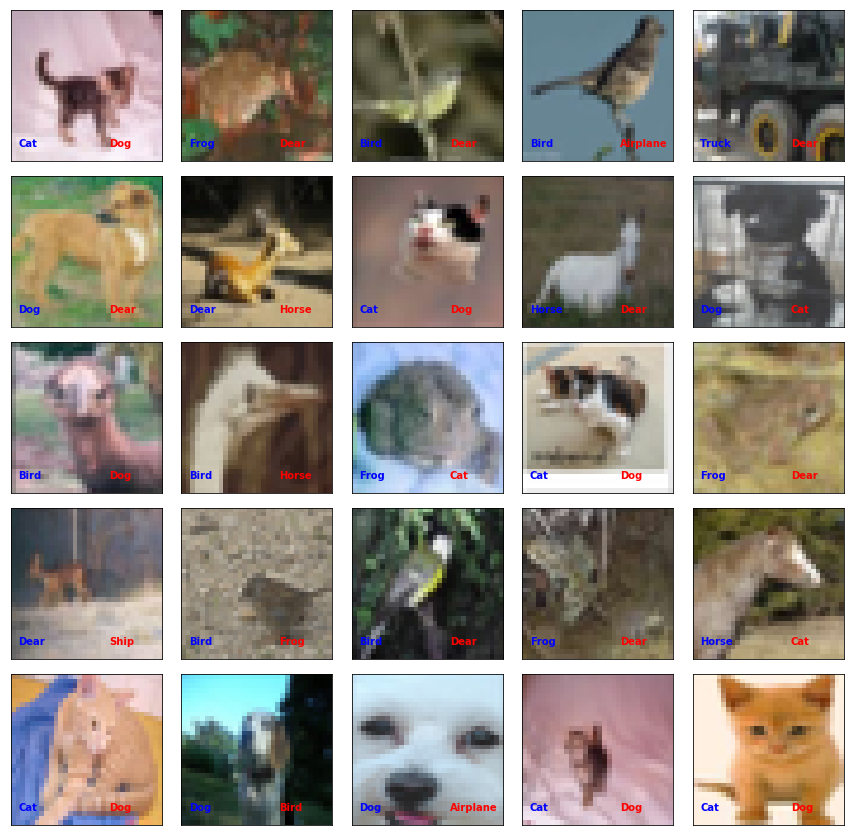


Good prediction


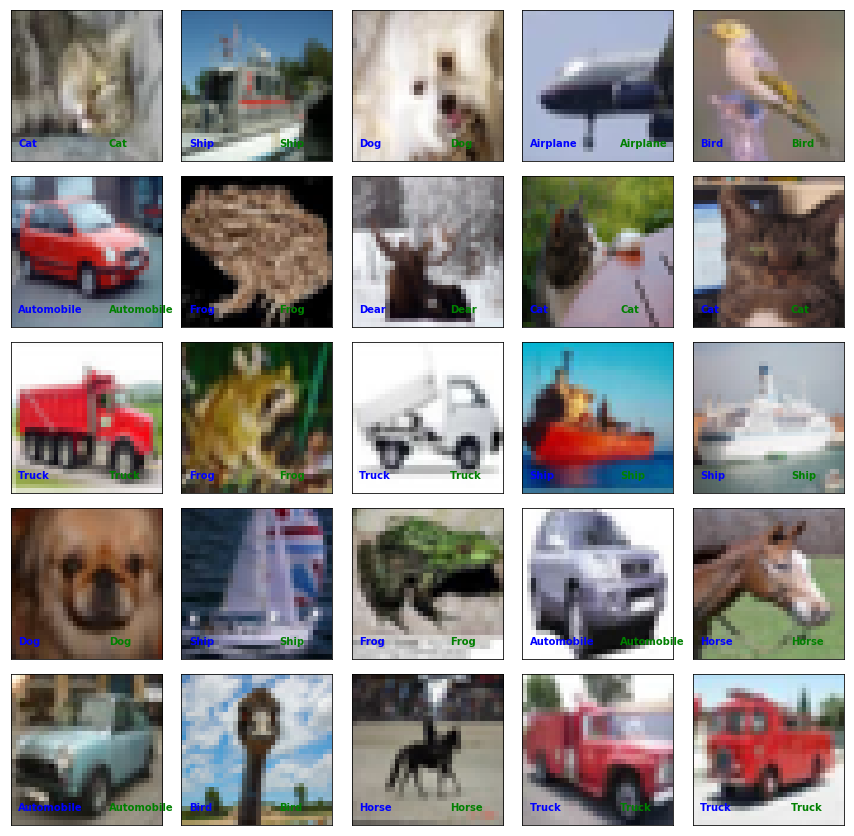

In [0]:
print_bad_good_preds(X_test, y_test, adamax_model)


### Confusion matrix

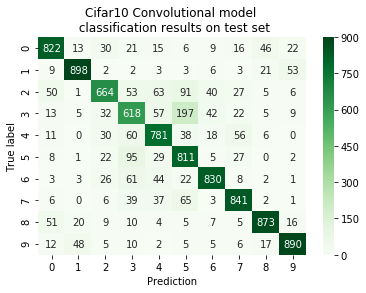

In [0]:
print_confusion_matrix(X_test, y_test, adamax_model)

### Error analysis

As we observe the confusion matrix we can see that the model confusing cats with dogs. We think that is becuase the background of the two are similar and that both cats and dogs are more likely to be photographed in the same setting. e.g houses, gardens and streets. 

### model history and accuracy on test

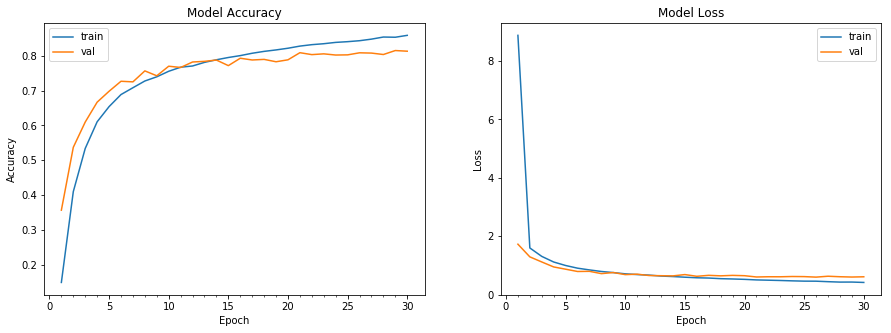

Model took 2657.56 seconds to train
Accuracy on test data is: 80.28


In [0]:
# plot model history
plot_model_history(adamax_model_info.history)
print("Model took %0.2f seconds to train"%(end_time - start_time))
# compute test accuracy
print("Accuracy on test data is: %0.2f"%(accuracy(X_test, y_test, adamax_model)))

#### We can see almost 14% of accuracy improvment (val_acc: 0.8130 - val_acc: 0.6773 ) on the validation data. In addition the accuray improvment on the test data is about 12.65% (80.28% - 67.63%)

***The second improve*** will be add batch normalization layer befor each block and using adamax optimizer

In [0]:
norm_model = Sequential()
x_input = Input(shape=(32, 32,3))
norm_model(x_input)

norm_model.add(BatchNormalization())
norm_model.add(Conv2D(48, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
norm_model.add(Conv2D(48, (3, 3), activation='relu'))
norm_model.add(MaxPooling2D(pool_size=(2, 2)))
norm_model.add(Dropout(0.25))

norm_model.add(BatchNormalization())
norm_model.add(Conv2D(96, (3, 3), activation='relu', padding='same'))
norm_model.add(Conv2D(96, (3, 3), activation='relu'))
norm_model.add(MaxPooling2D(pool_size=(2, 2)))
norm_model.add(Dropout(0.25))

norm_model.add(BatchNormalization())
norm_model.add(Conv2D(192, (3, 3), activation='relu', padding='same'))
norm_model.add(Conv2D(192, (3, 3), activation='relu'))
norm_model.add(MaxPooling2D(pool_size=(2, 2)))
norm_model.add(Dropout(0.25))

norm_model.add(BatchNormalization())
norm_model.add(Flatten())
norm_model.add(Dense(256,activation='relu'))
norm_model.add(Dropout(0.5))
norm_model.add(Dense(10, activation='softmax'))
norm_model.compile(loss='categorical_crossentropy',optimizer='adamax',metrics=['accuracy'])
norm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 48)        20784     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 48)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 15, 48)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 15, 15, 48)        192       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 96)        41568     
__________

In [0]:
start_time = time.time()
norm_model_info = norm_model.fit(X_train,to_categorical(y_train),validation_split=validation_split,shuffle=True,epochs=epochs)
end_time = time.time()

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 103s 3ms/step - loss: 1.7622 - acc: 0.3810 - val_loss: 1.3576 - val_acc: 0.5106
Epoch 2/30
40000/40000 [==============================] - 101s 3ms/step - loss: 1.2241 - acc: 0.5665 - val_loss: 0.9877 - val_acc: 0.6432
Epoch 3/30
40000/40000 [==============================] - 102s 3ms/step - loss: 0.9944 - acc: 0.6540 - val_loss: 0.8896 - val_acc: 0.6808
Epoch 4/30
40000/40000 [==============================] - 102s 3ms/step - loss: 0.8757 - acc: 0.6993 - val_loss: 0.8362 - val_acc: 0.7012
Epoch 5/30
40000/40000 [==============================] - 101s 3ms/step - loss: 0.7802 - acc: 0.7295 - val_loss: 0.6733 - val_acc: 0.7636
Epoch 6/30
40000/40000 [==============================] - 101s 3ms/step - loss: 0.7172 - acc: 0.7544 - val_loss: 0.6752 - val_acc: 0.7653
Epoch 7/30
40000/40000 [==============================] - 103s 3ms/step - loss: 0.6544 - acc: 0.7769 - val_loss: 0.6028 - 

In [0]:
save_model(norm_model,'norm_model')
save_model_info(norm_model_info,'norm_model_info')

In [0]:
norm_model = read_model(filename='norm_model')
norm_model_info = read_model_info('norm_model_info')

### Preditction results (example for good and bad classification ) :

Bad prediction


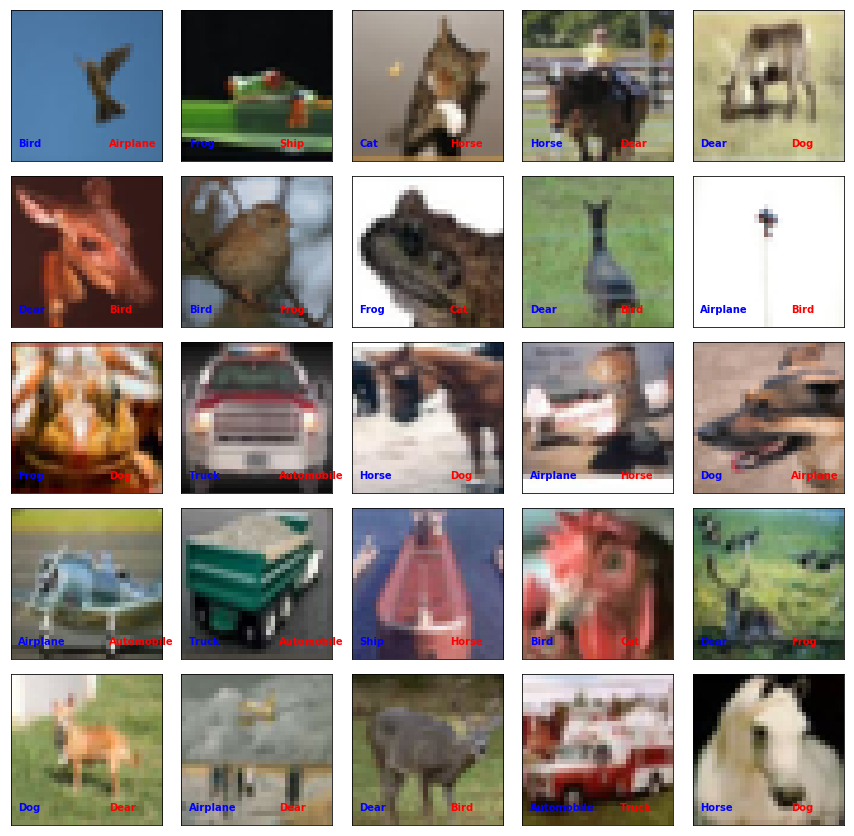


Good prediction


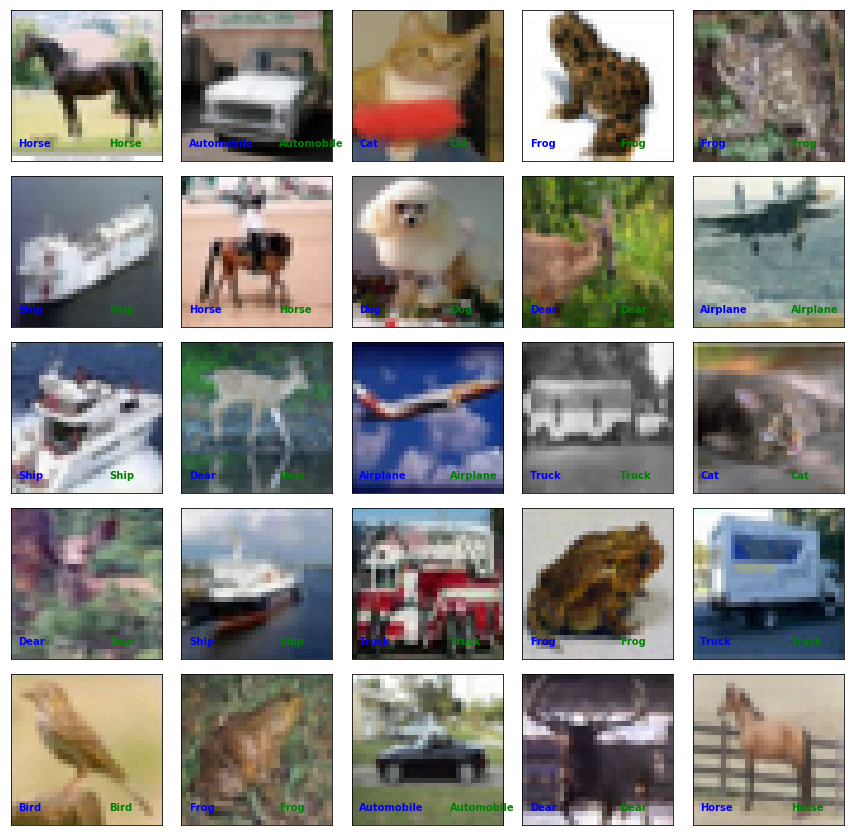

In [0]:
print_bad_good_preds(X_test, y_test, norm_model)

### Error analysis

We can see below the "bad prediction" title which represented above the following mistakes:
in raw number 4 and column number 1 we can see a tough example because the sample include an airplane on a road and not in the sky like many other airplanes as shown below  the "good prediction" title.

Anther tough smaple is in row 2 and column 5. the sample include a small airplane. This size of object in this type of background is more likely to be a bird an indeed that is what the model predicts.

### Confusion matrix

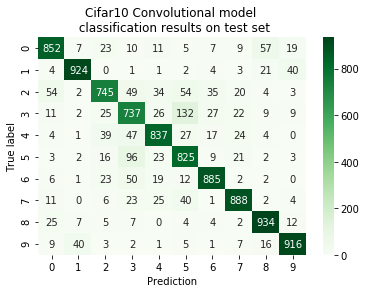

In [0]:
print_confusion_matrix(X_test, y_test, norm_model)

### model history and accuracy on test

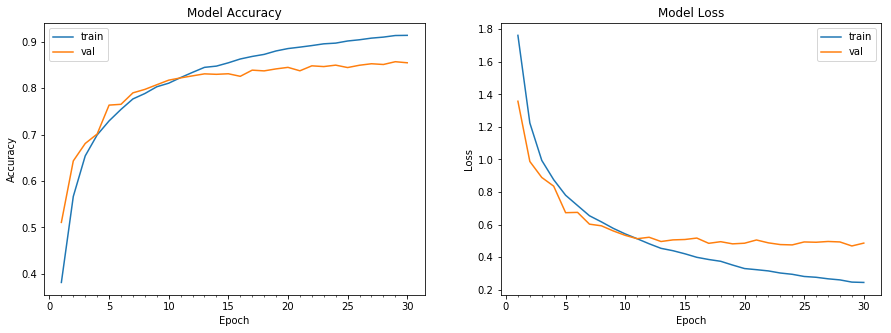

Model took 3105.67 seconds to train
Accuracy on test data is: 85.43


In [0]:
plot_model_history(norm_model_info.history)
print("Model took %0.2f seconds to train"%(end_time - start_time))
# compute test accuracy
print("Accuracy on test data is: %0.2f"%(accuracy(X_test, y_test, norm_model)))

#### We can see almost 18% of accuracy improvment (val_acc: 0.8549 - val_acc: 0.6773 ) on the validation data. In addition the accuray improvment on the test data is about 17.8% (85.43% - 67.63%)

# Section 3

***a)***

In [19]:
from keras.applications.vgg16 import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
last = base_model.get_layer('block3_pool').output

x = Flatten()(last)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
pred = Dense(10, activation='softmax')(x)
vgg16_model = Model(base_model.input, pred)

for layer in base_model.layers:
     layer.trainable = False
    
vgg16_model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

***b)*** we use augmentation for pre proccesing



In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
datagen = ImageDataGenerator(horizontal_flip=True, zoom_range=0.2, width_shift_range=0.15, height_shift_range=0.15, rotation_range=10)
datagen.fit(X_train)

***c)*** repeat section 2b for the model from section 3a using the preproccesing from secton 3b.

In [0]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(patience=3)

In [25]:
start_time = time.time()
vgg16_model_info = vgg16_model.fit_generator(datagen.flow(X_train[:40000],to_categorical(y_train[:40000]), batch_size=32),
                    validation_data=datagen.flow(X_train[40000:],to_categorical(y_train[40000:]), batch_size=32),
                    steps_per_epoch=int(len(X_train)*0.8)//32,validation_steps = int(len(X_train)*0.2)//32, epochs=30, callbacks=[es])
end_time = time.time()

Epoch 1/30
1250/1250 [==============================] - 42s 34ms/step - loss: 0.1382 - acc: 0.9466 - val_loss: 0.1305 - val_acc: 0.9495
Epoch 2/30
1250/1250 [==============================] - 43s 34ms/step - loss: 0.1363 - acc: 0.9470 - val_loss: 0.1290 - val_acc: 0.9502
Epoch 3/30
1250/1250 [==============================] - 42s 34ms/step - loss: 0.1338 - acc: 0.9483 - val_loss: 0.1318 - val_acc: 0.9490
Epoch 4/30
1250/1250 [==============================] - 43s 34ms/step - loss: 0.1341 - acc: 0.9483 - val_loss: 0.1279 - val_acc: 0.9506
Epoch 5/30
1250/1250 [==============================] - 43s 34ms/step - loss: 0.1331 - acc: 0.9484 - val_loss: 0.1280 - val_acc: 0.9504
Epoch 6/30
1250/1250 [==============================] - 43s 34ms/step - loss: 0.1319 - acc: 0.9493 - val_loss: 0.1233 - val_acc: 0.9523
Epoch 7/30
1250/1250 [==============================] - 42s 34ms/step - loss: 0.1307 - acc: 0.9493 - val_loss: 0.1244 - val_acc: 0.9525
Epoch 8/30
1250/1250 [==========================

In [0]:
save_model(vgg16_model, 'vgg16Model_block3_aog2')
save_model_info(vgg16_model_info, 'vgg16Model_block3_aog2')

In [0]:
vgg16_model = read_model(filename='vgg16Model')
vgg16_model_info = read_model_info('vgg16ModelHistory')

### preprocess the test set. 

### Confusion matrix

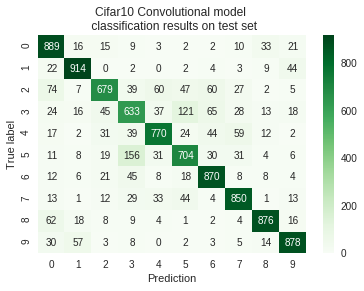

In [27]:
# block 3 + ago
print_confusion_matrix(X_test, y_test, vgg16_model)

### Error analysis

We can see below the "bad prediction" title which represented above the following mistakes:
in raw number 3 and column number 5 we can see a tough example because the sample include two presons that stand infront of the car hide the main object that the model trying to identify.

### model history and accuracy on test

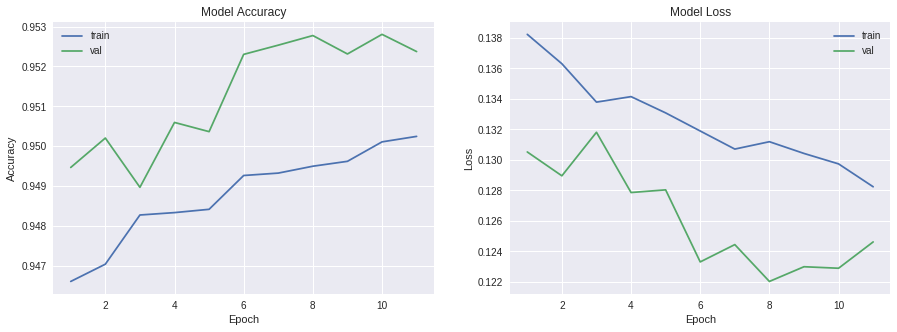

Model took 464.75 seconds to train
Accuracy on test data is: 80.63


In [28]:
# plot model history
plot_model_history(vgg16_model_info.history)
print("Model took %0.2f seconds to train"%(end_time - start_time))
# compute test accuracy
print("Accuracy on test data is: %0.2f"%(accuracy(X_test, y_test, vgg16_model)))

***d)*** Feature extraction

We choosed to use logistic regression

In [0]:
fe_X_train = vgg16_model.predict(X_train)
fe_X_test = vgg16_model.predict(X_test)

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

lrc = LogisticRegression(n_jobs=8,solver='lbfgs')
lrc.fit(fe_X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=8,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [58]:
result = lrc.predict(fe_X_test)
labels = np.reshape(y_test, len(y_test))
num_correct = np.sum(result == labels)
accuracy = (float(num_correct)/result.shape[0])*100
print("Accuracy on test data is: %0.2f"%(accuracy))

Accuracy on test data is: 81.06


# Section 4 Summary

At the start of our research we try to get as much information about the CIFAR10 dataset. And represented the most relational knowledge we found.

**First model** 
> At first, we wanted a good starting model with a potential to improve. We knew that the network should be a convolutional network because CIFAR10 dataset is an image dataset.

> At the beginning of our research we build a small CNN using 2 blocks each contain: two convulsion layers, a dropout layer and max polling. With addition of a dense layer of size 10 at the end. After some experiment with this network we learned that it is too small and diseased to search the internet for some similar research.

> We found a big model that needed a lot of parameters to train. At the beginning we adapted the model architecture but, understood that such a model should use a larger dataset. So we started to reduce the number of parameters that the model needs to train. At the end of this part of our research we got a model that have a 67% of accuracy over the test samples.

> At this stage of the research we started to think of ways to improve our base model such as: augmentation, choose validation data in random way,improving the learning rate, increases the numbers of epochs and using batch normalization. In addition we tried to add more layers and had some experiment with that. After a lot of trial and errors we took the improved models with the best results: 80% accuracy for the "adamax" model and: 85% accuracy for the "norm" model.

> As part of our will to improve the model (and as we were asked to do) we represented the prediction result in a few ways. We mainly use the confusion matrix and showing some samples of bad predictions. From the second we learned how the background is affected the model answer. For example a blue sky behind a bird makes the model predict it’s an airplane (This is his logic-based assumption).

***Transfer learning***
> We began this part of our research with trial and error with VGG19 sometimes with
include_top = False, and sometimes with include_top = True and by using padding as pre-processing. After getting no more than 63.57% accuracy over the test set we decided to switch for a different network such as Xception or VGG16. As we experimented we tryed to use diffrent techniques of pre processing such as normalize the input with the imagenet mean and std, and resize the input to (224, 224, 3). using this techniques we improve the model up to 76% accuracy. We thought taht is not enough so we tryed to take less from vgg16, insted of getting all the layers up to the fifth block we took up to the third block. At this point we also try to lose the pre processing and use input shape (32, 32, 3) and got 78% accuracy over the test set. But we were not satisfied with this results so we tryed to use augmentation witch led to the best result 80% in this section.

***Feature extractor***
> This part of the research taught us that we can use our pre-trained model to see if it learn someting more specific about the dataset so we can use to our benefit. And indeed the model improved by 1%.


***Conclusion***
> We learned from the research about CNNs and how to think about ways to improve the model. Furthermore we experiment in transfer learning and feature extracting and sow how it’s affected the prediction result over the validation set and test set.
